In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [2]:
# Model Hyperparameters

home_dir = os.environ["HOME"]
dataset_path = os.path.join(home_dir, "minerl/PyTorch-VAE/datasets/first_discrete/combined_gray")

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 24
img_size = (400, 300) # (100, 75) # (width, height)

input_dim = 1
hidden_dim = 200 # 128
n_embeddings= 1000 # 768
output_dim = 1

lr = 1e-4

epochs = 5

print_step = 50

###    Step 1. Load (or download) Dataset

In [3]:
# custom dataset for minecraft grayscale images
from PIL import Image
from torch.utils.data import Dataset
from natsort import natsorted

class MinecraftDataSet(Dataset):
    def __init__(self, main_dir, transform, train=True):
        if train:
            self.main_dir = os.path.join(main_dir, "train")
        else:
            self.main_dir = os.path.join(main_dir, "val")
        self.transform = transform
        all_imgs = os.listdir(self.main_dir)
        self.total_imgs = natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("L")
        tensor_image = self.transform(image)
        return tensor_image

In [4]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mc_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((300, 400)),
])

kwargs = {'num_workers': 4, 'pin_memory': True} 

train_dataset = MinecraftDataSet(dataset_path, transform=mc_transform, train=True)
test_dataset  = MinecraftDataSet(dataset_path, transform=mc_transform, train=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=True,  **kwargs)

### Step 2. Define our model: Vector Quantized Variational AutoEncoder (VQ-VAE)

In [5]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=(4, 4, 3, 1), stride=2):
        super(Encoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_size
        
        self.strided_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, stride, padding=1)
        self.strided_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, stride, padding=1)
        
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_3, padding=1)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, output_dim, kernel_4, padding=0)
        
    def forward(self, x):
        
        x = self.strided_conv_1(x)
        x = self.strided_conv_2(x)
        
        x = F.relu(x)
        y = self.residual_conv_1(x)
        y = y+x
        
        x = F.relu(y)
        y = self.residual_conv_2(x)
        y = y+x
        
        return y

In [6]:
class VQEmbeddingEMA(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25, decay=0.999, epsilon=1e-5):
        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon
        
        init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())

    def encode(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        distances = torch.addmm(torch.sum(self.embedding ** 2, dim=1) +
                    torch.sum(x_flat ** 2, dim=1, keepdim=True),
                                x_flat, self.embedding.t(),
                                alpha=-2.0, beta=1.0)

        indices = torch.argmin(distances.float(), dim=-1)
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        return quantized, indices.view(x.size(0), x.size(1))
    
    def retrieve_random_codebook(self, random_indices):
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)
        
        return quantized

    def forward(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)
        
        distances = torch.addmm(torch.sum(self.embedding ** 2, dim=1) +
                                torch.sum(x_flat ** 2, dim=1, keepdim=True),
                                x_flat, self.embedding.t(),
                                alpha=-2.0, beta=1.0)

        indices = torch.argmin(distances.float(), dim=-1)
        encodings = F.one_hot(indices, M).float()
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        
        if self.training:
            self.ema_count = self.decay * self.ema_count + (1 - self.decay) * torch.sum(encodings, dim=0)
            n = torch.sum(self.ema_count)
            self.ema_count = (self.ema_count + self.epsilon) / (n + M * self.epsilon) * n

            dw = torch.matmul(encodings.t(), x_flat)
            self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

        codebook_loss = F.mse_loss(x.detach(), quantized)
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_sizes=(1, 3, 2, 2), stride=2):
        super(Decoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_sizes
        
        self.residual_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, padding=0)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, padding=1)
        
        self.strided_t_conv_1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_3, stride, padding=0)
        self.strided_t_conv_2 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_4, stride, padding=0)
        
    def forward(self, x):
        
        y = self.residual_conv_1(x)
        y = y+x
        x = F.relu(y)
        
        y = self.residual_conv_2(x)
        y = y+x
        y = F.relu(y)
        
        y = self.strided_t_conv_1(y)
        y = self.strided_t_conv_2(y)
        
        return y

In [8]:
class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder
                
    def forward(self, x):
        z = self.encoder(x)
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)
        x_hat = self.decoder(z_quantized)
        
        return x_hat, commitment_loss, codebook_loss, perplexity    

In [9]:
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=hidden_dim)
codebook = VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=hidden_dim)
decoder = Decoder(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [10]:
from torch.optim import Adam

mse_loss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Vector Quantized Variational AutoEncoder (VQ-VAE)

In [11]:
print("Start training VQ-VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, x in enumerate(train_loader):
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
        # print(x_hat.shape, x.shape)
        recon_loss = mse_loss(x_hat, x)
        
        loss =  recon_loss + commitment_loss + codebook_loss
                
        loss.backward()
        optimizer.step()
        
        if batch_idx % print_step ==0: 
            print("epoch:", epoch + 1, "  step:", batch_idx + 1, "  recon_loss:", recon_loss.item(), "  perplexity: ", perplexity.item(), 
              "\n\t\tcommit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item(), "  total_loss: ", loss.item())
    
print("Finish!!")

Start training VQ-VAE...
epoch: 1   step: 1   recon_loss: 0.06047738716006279   perplexity:  26.638320922851562 
		commit_loss:  0.0026882037054747343   codebook loss:  0.010752814821898937   total_loss:  0.0739184021949768
epoch: 1   step: 51   recon_loss: 0.009863059967756271   perplexity:  66.53995513916016 
		commit_loss:  0.004342443309724331   codebook loss:  0.017369773238897324   total_loss:  0.0315752774477005
epoch: 1   step: 101   recon_loss: 0.009713768027722836   perplexity:  90.32158660888672 
		commit_loss:  0.003423645393922925   codebook loss:  0.0136945815756917   total_loss:  0.02683199569582939
epoch: 1   step: 151   recon_loss: 0.008591188117861748   perplexity:  99.06111145019531 
		commit_loss:  0.004058367107063532   codebook loss:  0.016233468428254128   total_loss:  0.02888302318751812
epoch: 1   step: 201   recon_loss: 0.008313171565532684   perplexity:  138.5892791748047 
		commit_loss:  0.004611317999660969   codebook loss:  0.018445271998643875   total_los

epoch: 1   step: 2051   recon_loss: 0.0035208638291805983   perplexity:  515.1598510742188 
		commit_loss:  0.008191242814064026   codebook loss:  0.032764971256256104   total_loss:  0.044477079063653946
epoch: 1   step: 2101   recon_loss: 0.0034268610179424286   perplexity:  527.8052368164062 
		commit_loss:  0.008055262267589569   codebook loss:  0.032221049070358276   total_loss:  0.043703172355890274
epoch: 1   step: 2151   recon_loss: 0.0033070705831050873   perplexity:  508.97406005859375 
		commit_loss:  0.00780968414619565   codebook loss:  0.0312387365847826   total_loss:  0.0423554927110672
epoch: 1   step: 2201   recon_loss: 0.003969746176153421   perplexity:  508.3757019042969 
		commit_loss:  0.008446073159575462   codebook loss:  0.03378429263830185   total_loss:  0.046200111508369446
epoch: 1   step: 2251   recon_loss: 0.0032968756277114153   perplexity:  509.37322998046875 
		commit_loss:  0.008026299066841602   codebook loss:  0.03210519626736641   total_loss:  0.04342

epoch: 2   step: 1701   recon_loss: 0.003455026540905237   perplexity:  614.9290161132812 
		commit_loss:  0.009789411909878254   codebook loss:  0.039157647639513016   total_loss:  0.052402086555957794
epoch: 2   step: 1751   recon_loss: 0.0026617534458637238   perplexity:  530.7534790039062 
		commit_loss:  0.008544228039681911   codebook loss:  0.034176912158727646   total_loss:  0.045382894575595856
epoch: 2   step: 1801   recon_loss: 0.004082212224602699   perplexity:  598.2973022460938 
		commit_loss:  0.009321514517068863   codebook loss:  0.03728605806827545   total_loss:  0.05068978667259216
epoch: 2   step: 1851   recon_loss: 0.0033583228942006826   perplexity:  593.442626953125 
		commit_loss:  0.009437424130737782   codebook loss:  0.037749696522951126   total_loss:  0.05054544284939766
epoch: 2   step: 1901   recon_loss: 0.0028251681942492723   perplexity:  553.639892578125 
		commit_loss:  0.008614915423095226   codebook loss:  0.034459661692380905   total_loss:  0.045899

epoch: 3   step: 1351   recon_loss: 0.003477258374914527   perplexity:  594.2564697265625 
		commit_loss:  0.009097064845263958   codebook loss:  0.03638825938105583   total_loss:  0.048962581902742386
epoch: 3   step: 1401   recon_loss: 0.0028784058522433043   perplexity:  594.3290405273438 
		commit_loss:  0.008804958313703537   codebook loss:  0.03521983325481415   total_loss:  0.04690319672226906
epoch: 3   step: 1451   recon_loss: 0.002571969060227275   perplexity:  593.69140625 
		commit_loss:  0.008595827966928482   codebook loss:  0.03438331186771393   total_loss:  0.0455511100590229
epoch: 3   step: 1501   recon_loss: 0.0025121283251792192   perplexity:  578.7211303710938 
		commit_loss:  0.008275591768324375   codebook loss:  0.0331023670732975   total_loss:  0.0438900887966156
epoch: 3   step: 1551   recon_loss: 0.002750447252765298   perplexity:  591.4180297851562 
		commit_loss:  0.008811991661787033   codebook loss:  0.03524796664714813   total_loss:  0.04681040346622467


epoch: 4   step: 1001   recon_loss: 0.0028352176304906607   perplexity:  535.6362915039062 
		commit_loss:  0.008130328729748726   codebook loss:  0.032521314918994904   total_loss:  0.04348686337471008
epoch: 4   step: 1051   recon_loss: 0.0021431385539472103   perplexity:  560.1209106445312 
		commit_loss:  0.007406902965158224   codebook loss:  0.029627611860632896   total_loss:  0.039177652448415756
epoch: 4   step: 1101   recon_loss: 0.0023175629321485758   perplexity:  580.1341552734375 
		commit_loss:  0.008262702263891697   codebook loss:  0.03305080905556679   total_loss:  0.04363107308745384
epoch: 4   step: 1151   recon_loss: 0.002090971916913986   perplexity:  585.3184814453125 
		commit_loss:  0.007913450710475445   codebook loss:  0.03165380284190178   total_loss:  0.041658226400613785
epoch: 4   step: 1201   recon_loss: 0.0023918936494737864   perplexity:  585.0400390625 
		commit_loss:  0.008485376834869385   codebook loss:  0.03394150733947754   total_loss:  0.04481877

epoch: 5   step: 651   recon_loss: 0.0020770130213350058   perplexity:  596.3621826171875 
		commit_loss:  0.008469409309327602   codebook loss:  0.03387763723731041   total_loss:  0.044424060732126236
epoch: 5   step: 701   recon_loss: 0.0020684937480837107   perplexity:  583.043212890625 
		commit_loss:  0.007827281020581722   codebook loss:  0.03130912408232689   total_loss:  0.04120489954948425
epoch: 5   step: 751   recon_loss: 0.0018450005445629358   perplexity:  528.7682495117188 
		commit_loss:  0.007204683963209391   codebook loss:  0.028818735852837563   total_loss:  0.03786842152476311
epoch: 5   step: 801   recon_loss: 0.0018748210277408361   perplexity:  582.93505859375 
		commit_loss:  0.00797171052545309   codebook loss:  0.03188684210181236   total_loss:  0.04173337295651436
epoch: 5   step: 851   recon_loss: 0.002138496143743396   perplexity:  637.8877563476562 
		commit_loss:  0.008293792605400085   codebook loss:  0.03317517042160034   total_loss:  0.0436074584722518

### Step 5. Evaluate the model

In [12]:
import matplotlib.pyplot as plt

In [13]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(40,40))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

In [28]:
model.eval()

with torch.no_grad():

    for batch_idx, x in enumerate(tqdm(test_loader)):

        from time import perf_counter
        start = perf_counter() 
        x = x.to(DEVICE)
        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
        # print(x_hat.shape) # (128, 1, 72, 100)
        end = perf_counter()
        print("Elapsed time: ", end - start)
 
        print("perplexity: ", perplexity.item(),"commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
        break

  0%|          | 0/418 [00:00<?, ?it/s]

Elapsed time:  0.006419553988962434


  0%|          | 0/418 [00:00<?, ?it/s]

perplexity:  565.8523559570312 commit_loss:  0.007650410756468773   codebook loss:  0.03060164302587509


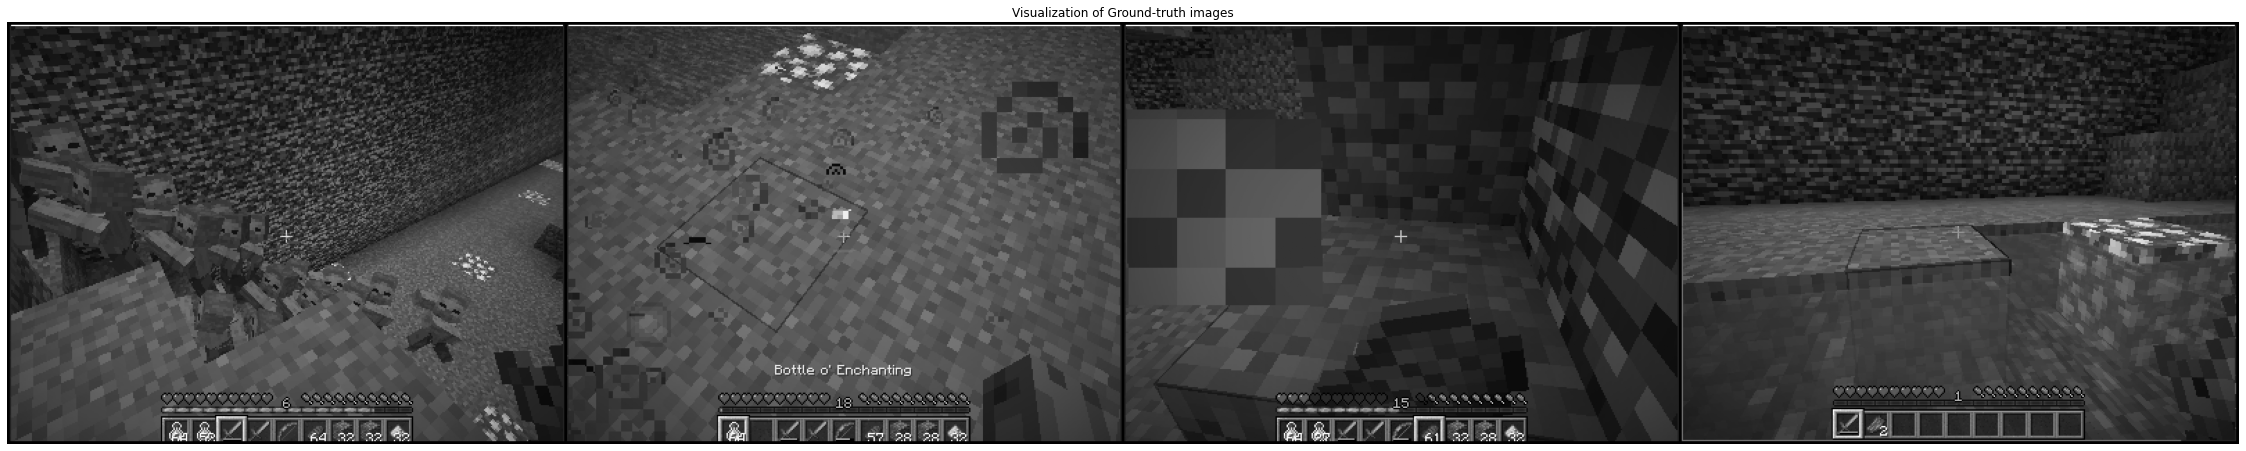

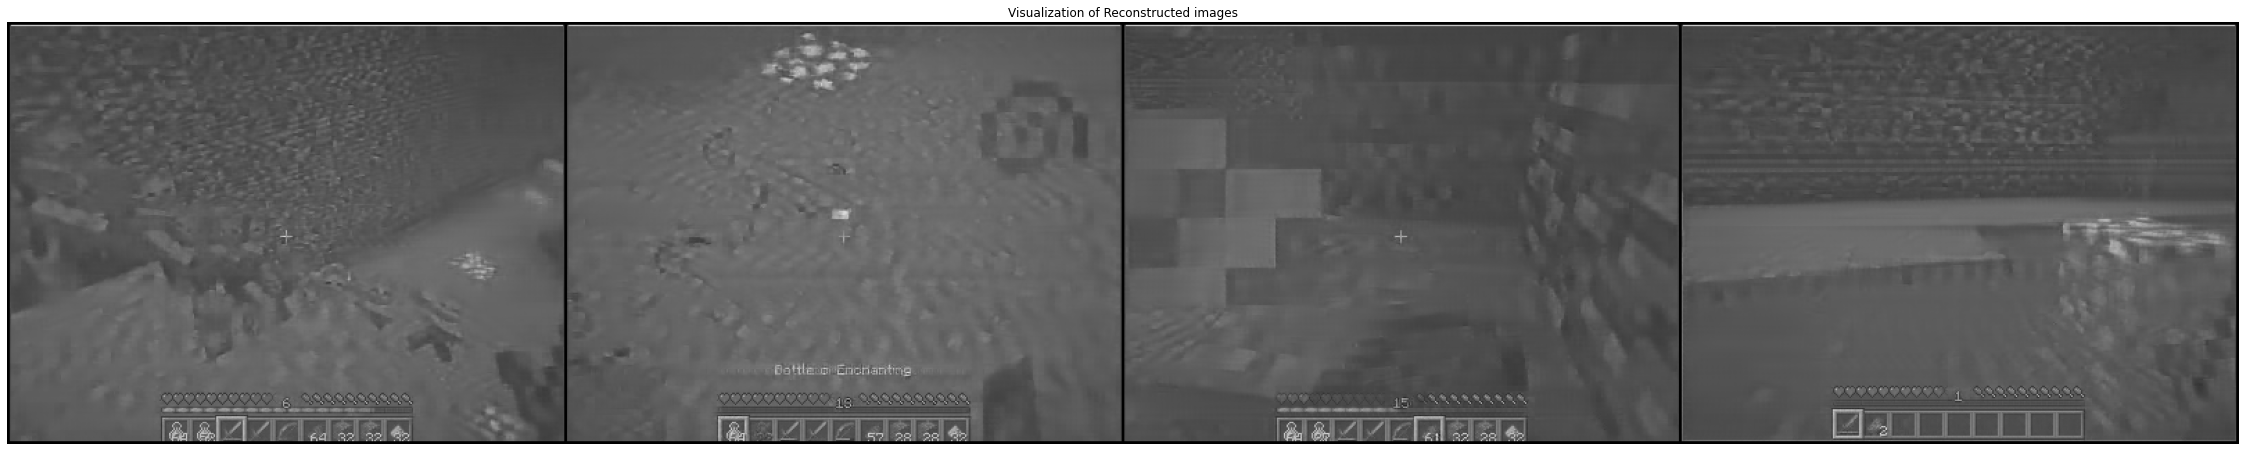

In [15]:
draw_sample_image(x[:batch_size//6], "Ground-truth images")
draw_sample_image(x_hat[:batch_size//6], "Reconstructed images")

In [16]:
def show_image(x, idx):
    x = x.view(-1, 300, 400)

    fig = plt.figure(figsize = (20,20))
    plt.imshow(x[idx].cpu().numpy(), cmap='gray', vmin=0, vmax=1)

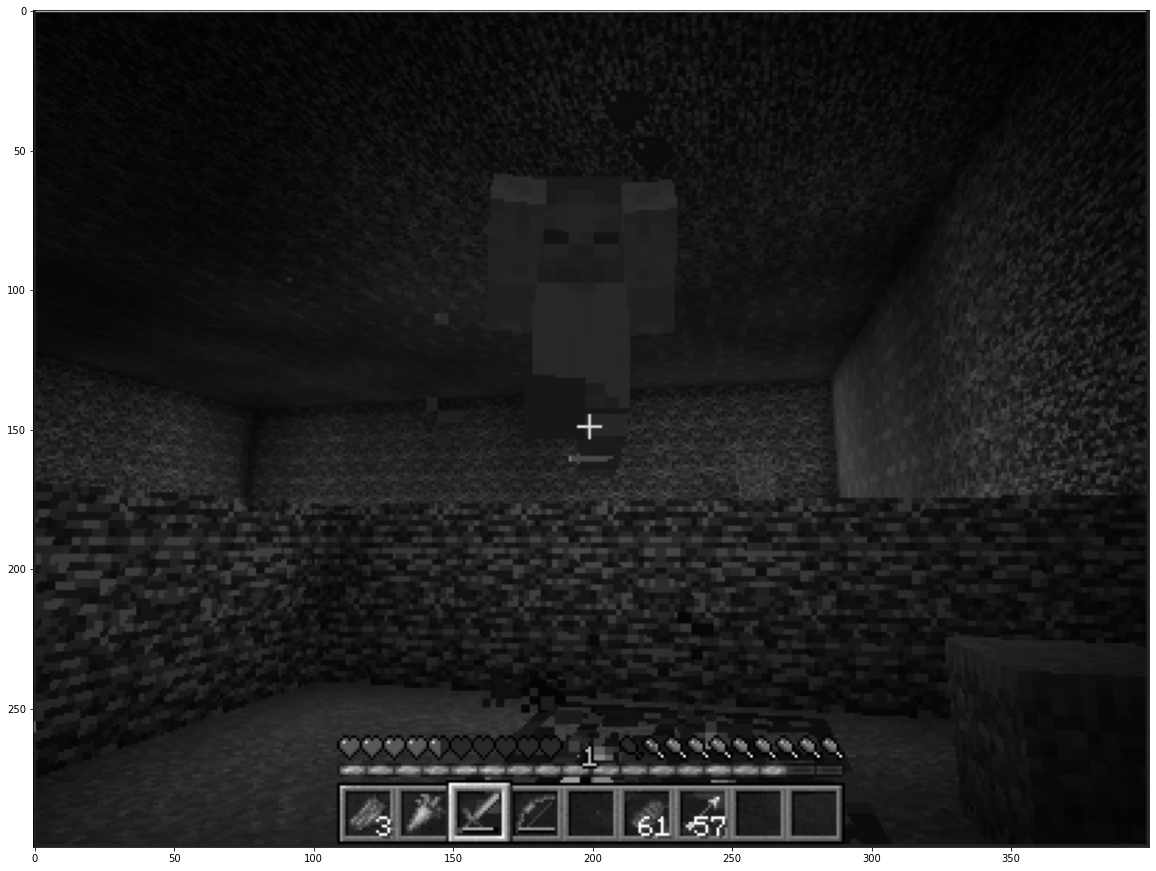

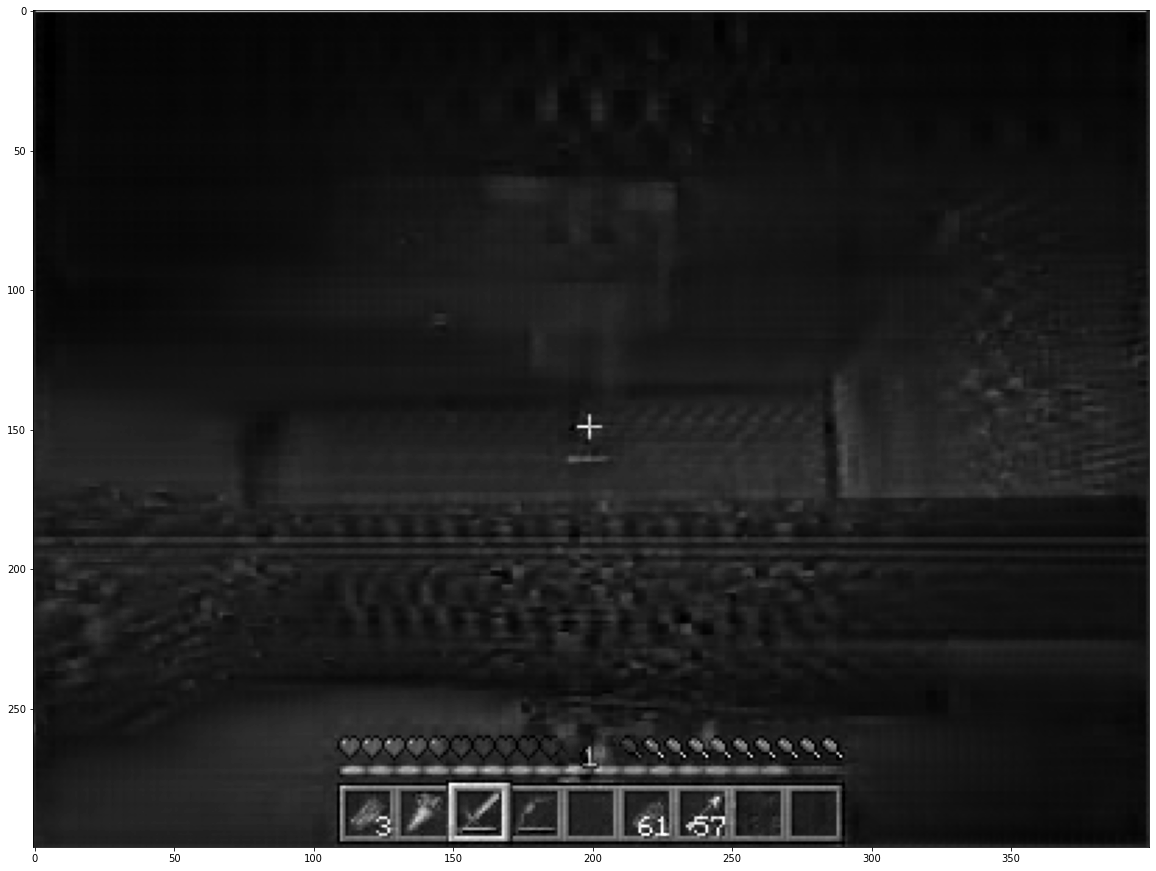

In [43]:
idx = 19
show_image(x, idx=idx)
show_image(x_hat, idx=idx)

### Step 6. Generate samples via random codes

In [30]:
def draw_random_sample_image(codebook, decoder, indices_shape):
    
    random_indices = torch.floor(torch.rand(indices_shape) * n_embeddings).long().to(DEVICE)
    codes = codebook.retrieve_random_codebook(random_indices)
    x_hat = decoder(codes.to(DEVICE))
    
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of Random Codes")
    plt.imshow(np.transpose(make_grid(x_hat.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

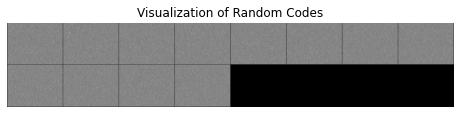

In [31]:
draw_random_sample_image(codebook, decoder, indices_shape=(batch_size//2, img_size[0]//4, img_size[1]//4))